# Kategorinen data ja puuttuvien arvojen käsittely

In [1]:
import pandas as pd 
import numpy as np 

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import os 

In [2]:
# luetaan data ja tallennetaan se csv-tiedostoon
if os.path.exists('abnd_listings.csv'):
    df = pd.read_csv('abnd_listings.csv')
else:
    df = pd.read_csv('https://raw.githubusercontent.com/InfoTUNI/joda2022/master/koodiesimerkit/data.csv')
    df.to_csv('abnd_listings.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 98 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0.1                      16313 non-null  int64  
 1   Unnamed: 0                        16313 non-null  int64  
 2   id                                16313 non-null  int64  
 3   listing_url                       16313 non-null  object 
 4   scrape_id                         16313 non-null  int64  
 5   last_scraped                      16313 non-null  object 
 6   name                              16302 non-null  object 
 7   summary                           15860 non-null  object 
 8   space                             11798 non-null  object 
 9   description                       16305 non-null  object 
 10  experiences_offered               16313 non-null  object 
 11  neighborhood_overview             10343 non-null  object 
 12  note

In [3]:
df_no_missing = df[['host_response_time', 'host_response_rate', 'review_scores_rating']].copy()

print(df_no_missing.head())
print(df_no_missing.host_response_time.unique())

  host_response_time host_response_rate  review_scores_rating
0       within a day                60%                  89.0
1     within an hour               100%                  91.0
2     within an hour               100%                  79.0
3     within an hour               100%                  90.0
4     within an hour               100%                  80.0
['within a day' 'within an hour' 'within a few hours' nan
 'a few days or more']


In [4]:
df_no_missing.host_response_rate = df_no_missing.host_response_rate.str.strip('%')
df_no_missing.host_response_rate = pd.to_numeric(df_no_missing.host_response_rate)

print(df_no_missing.info, '\n')
print(df_no_missing.dtypes, '\n')
print(df_no_missing.head(), '\n')

null_counts = df_no_missing.isnull().sum()
print(f"Null values count: \n {null_counts}")

<bound method DataFrame.info of        host_response_time  host_response_rate  review_scores_rating
0            within a day                60.0                  89.0
1          within an hour               100.0                  91.0
2          within an hour               100.0                  79.0
3          within an hour               100.0                  90.0
4          within an hour               100.0                  80.0
...                   ...                 ...                   ...
16308  within a few hours               100.0                   NaN
16309  within a few hours                70.0                   NaN
16310      within an hour               100.0                   NaN
16311      within an hour                96.0                   NaN
16312      within an hour                91.0                   NaN

[16313 rows x 3 columns]> 

host_response_time       object
host_response_rate      float64
review_scores_rating    float64
dtype: object 

  host_resp

In [5]:
# Pudotetaan rivit, joissa on puuttuvia arvoja
df_no_missing = df_no_missing.dropna()
df_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11855 entries, 0 to 16218
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_time    11855 non-null  object 
 1   host_response_rate    11855 non-null  float64
 2   review_scores_rating  11855 non-null  float64
dtypes: float64(2), object(1)
memory usage: 370.5+ KB


In [6]:
# Kategorisoidaan host_response_time -sarake
le = preprocessing.LabelEncoder()
arr = le.fit_transform(df_no_missing.host_response_time)
df_no_missing.host_response_time = arr 

In [7]:
print(arr)
df_no_missing.head()

[1 3 3 ... 3 3 3]


,host_response_time,host_response_rate,review_scores_rating
0,1,60.0,89.0
1,3,100.0,91.0
2,3,100.0,79.0
3,3,100.0,90.0
4,3,100.0,80.0


In [8]:
# Käytetään lineaarista mallia, joka ennustaa review_scores_rating -sarakeen arvoja.
lr = linear_model.LinearRegression()
y = df_no_missing.review_scores_rating
X = df_no_missing.drop(columns='review_scores_rating')


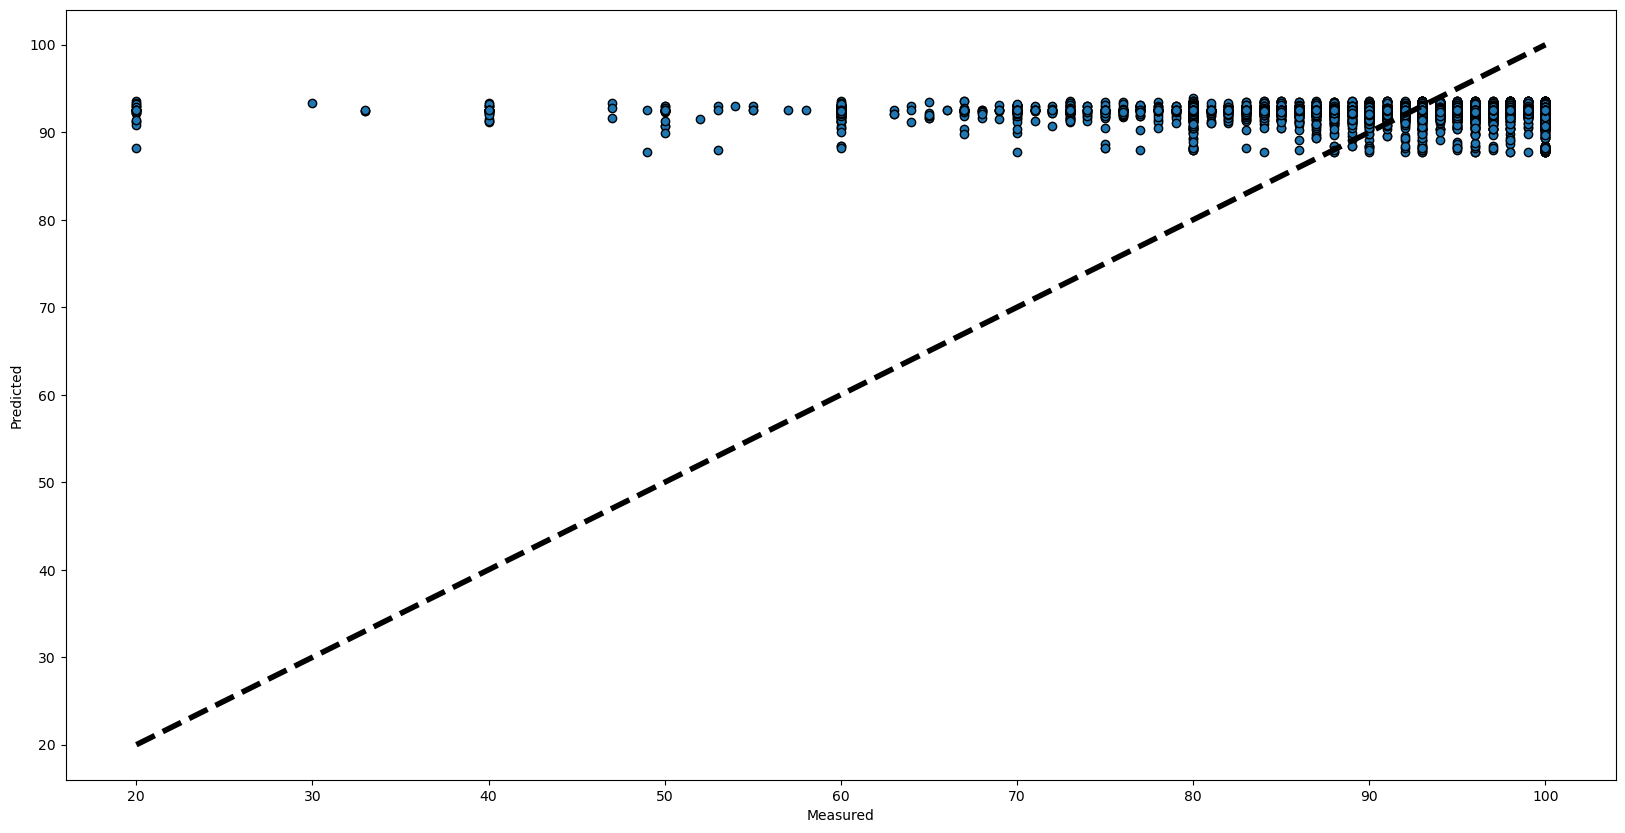

In [9]:
predictions = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize = (20,10))

ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [10]:
print(df_no_missing.corr())


                      host_response_time  host_response_rate  \
host_response_time              1.000000            0.586101   
host_response_rate              0.586101            1.000000   
review_scores_rating            0.018660            0.066256   

                      review_scores_rating  
host_response_time                0.018660  
host_response_rate                0.066256  
review_scores_rating              1.000000  


In [11]:
mse = mean_squared_error(predictions, y)
mae = mean_absolute_error(predictions, y)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

Mean squared error: 72.83
Mean absolute error: 5.72


# Toinen lähestymistapa - Täytetään tyhjät arvot mediaanilla 

In [12]:
df_imp = df[['review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication',
         'review_scores_location','review_scores_value',
         'review_scores_rating']].copy()

print(df_imp.isnull().sum())


review_scores_accuracy         3208
review_scores_cleanliness      3202
review_scores_checkin          3224
review_scores_communication    3209
review_scores_location         3230
review_scores_value            3231
review_scores_rating           3195
dtype: int64


In [13]:
# Tarkastellaan otettujen muuttujien mediaaneja
df_imp.median()

review_scores_accuracy         10.0
review_scores_cleanliness      10.0
review_scores_checkin          10.0
review_scores_communication    10.0
review_scores_location         10.0
review_scores_value             9.0
review_scores_rating           95.0
dtype: float64

In [14]:
# Lisätään tyhjiin arvioihin kyseiisten sarakkeiden mediaaniarvot
df_imp = df_imp.fillna(df_imp.median())
print(df_imp.isnull().sum())

review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
review_scores_rating           0
dtype: int64


In [15]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review_scores_accuracy       16313 non-null  float64
 1   review_scores_cleanliness    16313 non-null  float64
 2   review_scores_checkin        16313 non-null  float64
 3   review_scores_communication  16313 non-null  float64
 4   review_scores_location       16313 non-null  float64
 5   review_scores_value          16313 non-null  float64
 6   review_scores_rating         16313 non-null  float64
dtypes: float64(7)
memory usage: 892.2 KB


# Ennustetaan lineaarisella mallilla arvostelut jossa tyhjät arvot korvattu kyseisen sarakkeen mediaanilla

In [16]:
# Käytetään lineaarista mallia, joka ennustaa review_scores_rating -sarakeen arvoja.
lr = linear_model.LinearRegression()

y = df_imp.review_scores_rating
X = df_imp.drop(columns='review_scores_rating')

# Erotetaan testi ja opetusdata toisistaan
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

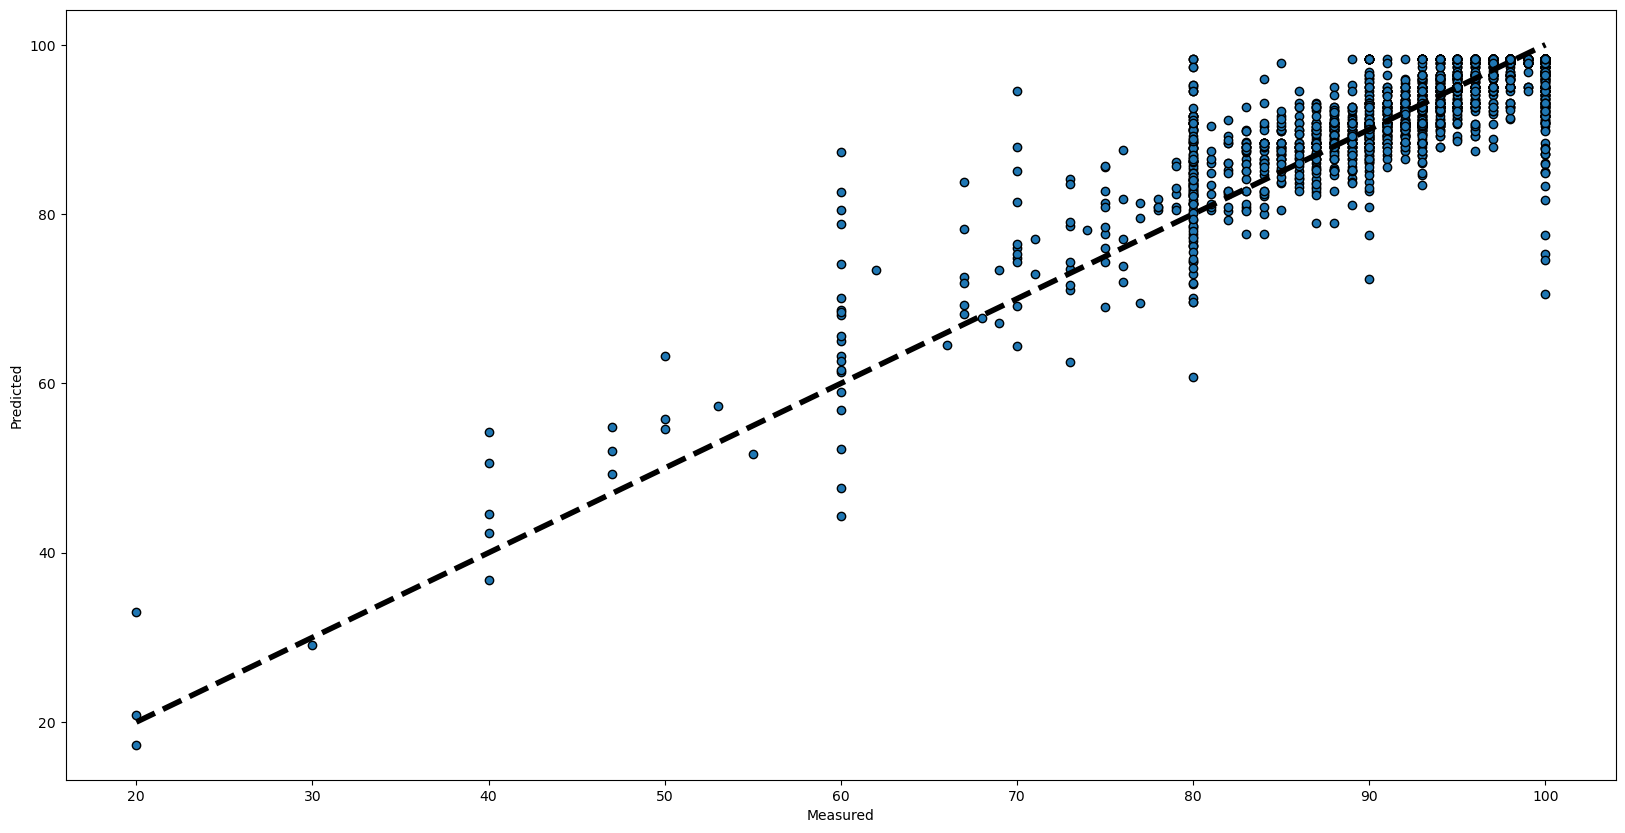

In [17]:
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [18]:
print(df_imp.corr()['review_scores_rating'])

review_scores_accuracy         0.759918
review_scores_cleanliness      0.702815
review_scores_checkin          0.632046
review_scores_communication    0.663075
review_scores_location         0.433515
review_scores_value            0.766700
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64


In [19]:
# Tarkastellaan lineaarisen mallin virheitä 

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Pidetään tällä yllä eri mallien suorituskykyä
models_performance = pd.DataFrame({'Model Name': ['Linear Regression'], 'MSE': [mse], 'MAE': [mae], 'time': [0.0]})


Mean squared error: 12.65
Mean absolute error: 2.16


# Käytetään satunnaista päätöspuumetsää ja optimoidaan hyperparametrit satunnaisella haulla 

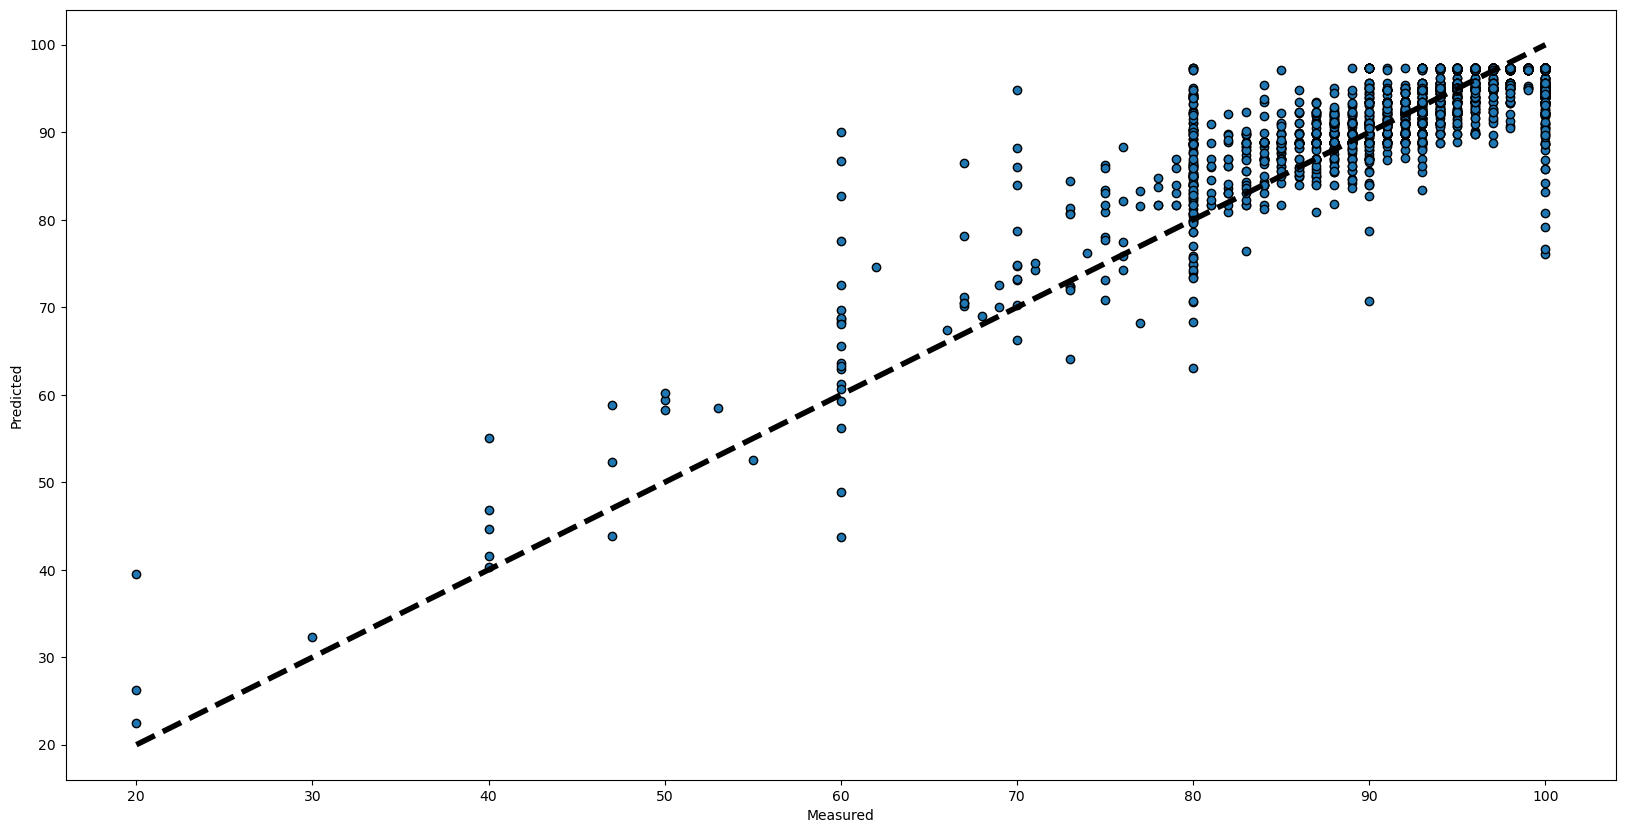

Mean squared error: 12.97
Mean absolute error: 2.22


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

rf = RandomForestRegressor()

# Määritellään hyperparametrien etsintäavaruus
param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Haetaan parhaat hyperparametrit
random_search = RandomizedSearchCV(
estimator = rf,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 1,
verbose = 0
)

start_time = time.time()
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
end_time = time.time()
elapsed_time = end_time - start_time

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X_test)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Tallennetaan mallin suorituskyky
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae], 'time' : [elapsed_time]})], ignore_index=True)


# Testataan XGBoost mallia ja etsitään sillekin hyperparametrit 

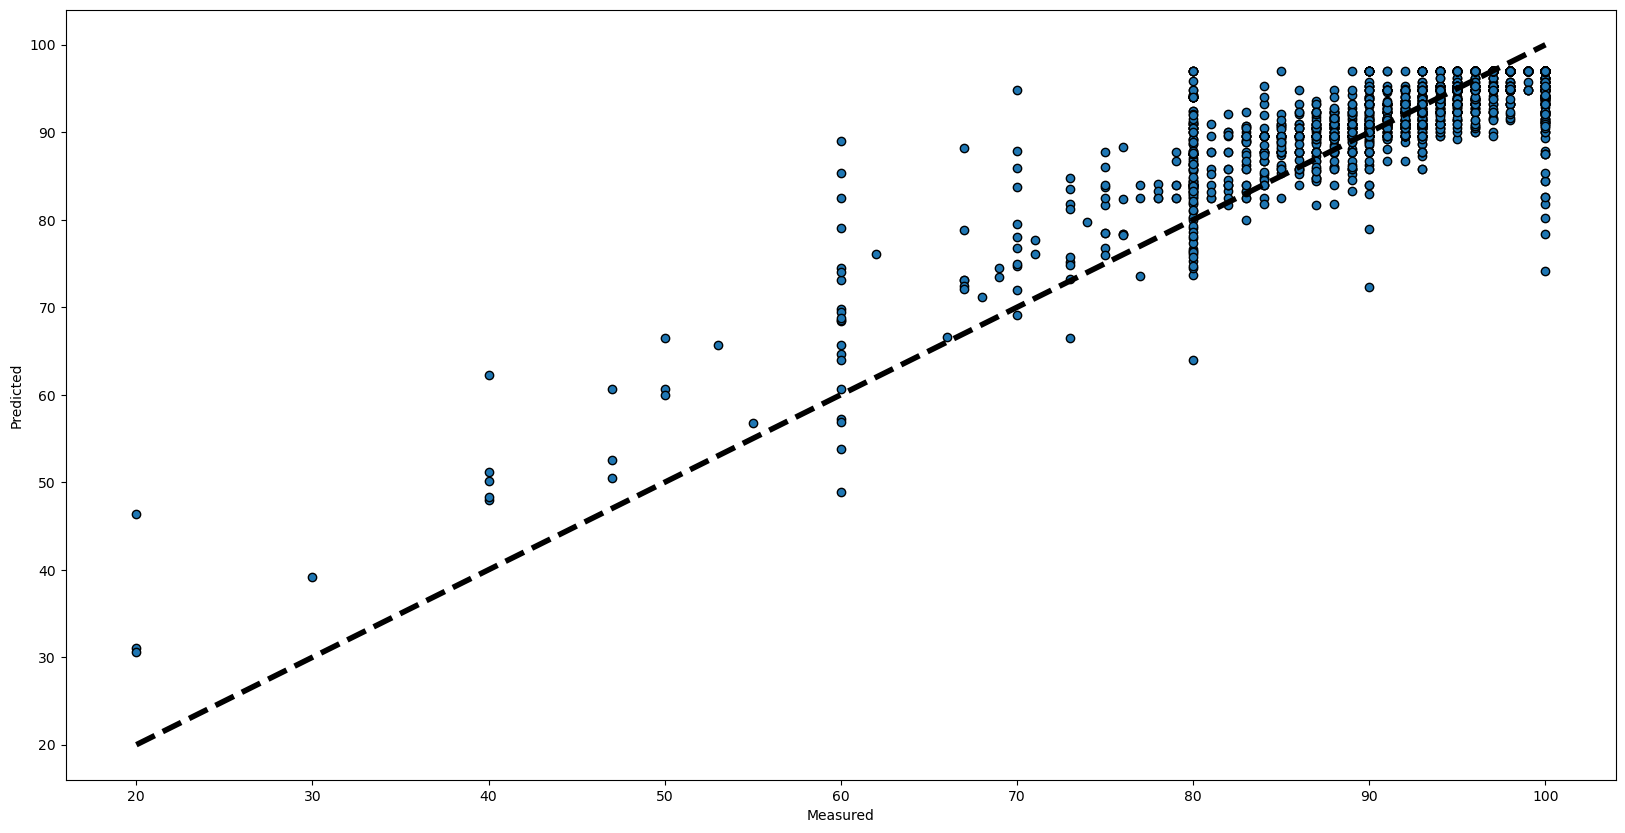

Mean squared error: 13.89
Mean absolute error: 2.32


In [21]:
import xgboost

# Käyetään xgboost -mallia MSE objektiivilla
xgb = xgboost.XGBRegressor(objective ='reg:squarederror')

param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2] 
}

random_search = RandomizedSearchCV(
estimator = xgb,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 1,
verbose = 0
)

start_time = time.time()
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
end_time = time.time()
elapsed_time = end_time - start_time

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X_test)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae], 'time' : [elapsed_time]})], ignore_index=True)

# Optimoidaan NN hyperparametrit ensin satunnaisella haulla

In [22]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from kerastuner import RandomSearch
from keras.callbacks import ModelCheckpoint, EarlyStopping

models = []

# Standardoi ominaisuudet
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    # Määritetään hakuavaruus neuroneiden määrälle 
    model.add(keras.layers.Dense(units=hp.Int('units_0', min_value=1, max_value=128, step=4), activation='relu'))
    model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=1, max_value=32, step=4), activation='relu'))        
    model.add(keras.layers.Dense(1, activation='linear'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),
                  loss='mse')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=1,
    executions_per_trial=1,
    directory='NN_search',
    project_name='kt_random')

start_time = time.time()
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test))

# Hae parasta mallia ja sen hyperparametrit ja opeta verkko näillä uudestaan pidemmällä koulutuksella
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Parhaat hyperparametrit:\n", best_hyperparameters.values)

model_random = build_model(best_hyperparameters)

checkpoint_filepath = './NN_search/kt_random/best_model_weights.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_random.fit(X_train_scaled, y_train, epochs=1, validation_data=(X_test_scaled, y_test), callbacks=[model_checkpoint_callback])
model_random.load_weights(checkpoint_filepath)
end_time = time.time()
elapsed_time = end_time - start_time
models.append(model_random)

predictions = model_random.predict(X_test_scaled)
mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae], 'time' : [elapsed_time]})], ignore_index=True)





2024-03-17 12:55:20.556112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 12:55:21.194371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_429891/4054369912.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch
2024-03-17 12:55:21.973802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


Reloading Tuner from NN_search/kt_random/tuner0.json
Parhaat hyperparametrit:
 {'units_0': 105, 'units_1': 29, 'learning_rate': 0.001}


2024-03-17 12:55:22.085254: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5722.5918 - val_loss: 374.0384
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean squared error: 374.08
Mean absolute error: 12.53


# Optimoidaan NN hyperparametrit käyttäen Bayesilaista optimointia

In [23]:
import tensorflow as tf
from keras_tuner import BayesianOptimization
from keras import regularizers, Sequential, layers, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    
    for i in range(2): 
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=1, max_value=128, step=4),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid', 'linear', 'elu', 'selu', 'softplus', 'softsign']),
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Float(f'l1_reg_{i}', min_value=1e-5, max_value=1e-1, sampling='log'),
                l2=hp.Float(f'l2_reg_{i}', min_value=1e-5, max_value=1e-1, sampling='log'))))
            
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)))

    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])), loss='mse')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=1,
    executions_per_trial=1,
    directory='NN_search',
    overwrite=True,
    project_name='kt_bayesian')

start_time = time.time()
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))
end_time = time.time()
elapsed_time = end_time - start_time

# Hae parasta mallia ja sen hyperparametrit ja opeta verkko näillä uudestaan pidemmällä koulutuksella
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Parhaat hyperparametrit:\n", best_hyperparameters.values)

model_bayes = build_model(best_hyperparameters)

checkpoint_filepath = './NN_search/kt_bayesian/best_model_weights.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_bayes.fit(X_train_scaled, y_train, epochs=1, validation_data=(X_test_scaled, y_test), callbacks=[model_checkpoint_callback])
model_bayes.load_weights(checkpoint_filepath)
models.append(model_bayes)

predictions = model_bayes.predict(X_test_scaled)
mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae], 'time' : [elapsed_time]})], ignore_index=True)


Reloading Tuner from NN_search/kt_bayesian/tuner0.json
Parhaat hyperparametrit:
 {'units_0': 113, 'activation_0': 'tanh', 'l1_reg_0': 0.0003238991714742434, 'l2_reg_0': 0.000488886312543524, 'dropout_0': 0.05, 'units_1': 93, 'activation_1': 'selu', 'l1_reg_1': 0.00012114205509704109, 'l2_reg_1': 0.00015355749455033574, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.01}
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1429.7400 - val_loss: 18.3220
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
Mean squared error: 18.03
Mean absolute error: 2.92


In [24]:
from keras_tuner import Hyperband
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers, Sequential, layers, optimizers
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_tuner import Hyperband
from keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from keras import regularizers, Sequential, layers, optimizers
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler 
from keras import initializers

# scaler = RobustScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_hyperparameters = []


def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    
    max_neurons = [128,16]
    min_neurons = [1,6]
    step_neurons = [4,1]

    initializer_name = hp.Choice(f'initializer', values=['he_normal', 'glorot_uniform', 'lecun_normal', 'glorot_normal'])
    if initializer_name == 'he_normal':
        initializer = initializers.HeNormal()
    elif initializer_name == 'glorot_uniform':
        initializer = initializers.GlorotUniform()
    elif initializer_name == 'lecun_normal':
        initializer = initializers.LecunNormal()
    else:
        initializer = initializers.GlorotNormal()

    for idx, i in enumerate(range(2)):
        
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=min_neurons[idx], max_value=max_neurons[idx], step=step_neurons[idx]),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid', 'linear', 'elu', 'selu']),
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Float(f'l1_reg_{i}', min_value=1e-6, max_value=1, sampling='log'),
                l2=hp.Float(f'l2_reg_{i}', min_value=1e-6, max_value=1, sampling='log')),
            kernel_initializer=initializer
                )
            )
            
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)))

    model.add(layers.Dense(1, activation='linear'))

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'nadam', 'AdaMax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'nadam':
        optimizer = optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.Adamax(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse')
    return model
    
kf = KFold(n_splits=3)
models_hyperband = []


round = 0
for train_index, val_index in kf.split(X_train_scaled):
    
    start_time = time.time()
    X_train_k, X_val_k = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train.index = range(len(y_train))
    y_train_k, y_val_k = y_train[train_index], y_train[val_index]

    y_train_k = tf.data.Dataset.from_tensor_slices(y_train_k)
    X_train_k = tf.data.Dataset.from_tensor_slices(X_train_k)
    train_dataset = tf.data.Dataset.zip((X_train_k, y_train_k)).batch(256)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    tuner = Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=50,
        factor=3,
        directory='NN_search',
        project_name='kt_hyperband',
        executions_per_trial=1,
        overwrite=True,
        hyperband_iterations=3
    )
        

    tuner.search(train_dataset, validation_data=(X_val_k, y_val_k), epochs=30, callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6)])
    end_time = time.time()
    elapsed_time = end_time - start_time

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters.append(tuner.get_best_hyperparameters(num_trials=1)[0])
    predictions = best_model.predict(X_test_scaled)
    mse = mean_squared_error(predictions, y_test)
    mae = mean_absolute_error(predictions, y_test)
    models_hyperband.append(best_model)

    print(f"Round: {round}")
    print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

    models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae], 'time' : [elapsed_time]})], ignore_index=True)
    round += 1


Trial 112 Complete [00h 00m 01s]
val_loss: 8069.92578125

Best val_loss So Far: 16.922149658203125
Total elapsed time: 00h 03m 49s

Search: Running Trial #113

Value             |Best Value So Far |Hyperparameter
glorot_uniform    |glorot_normal     |initializer
41                |53                |units_0
sigmoid           |elu               |activation_0
0.0064889         |1.092e-06         |l1_reg_0
1.0991e-06        |3.9341e-06        |l2_reg_0
0.05              |0.4               |dropout_0
9                 |6                 |units_1
sigmoid           |selu              |activation_1
0.00091945        |7.474e-06         |l1_reg_1
0.020288          |0.00068391        |l2_reg_1
0.3               |0                 |dropout_1
AdaMax            |rmsprop           |optimizer
0.0015581         |0.024576          |learning_rate
2                 |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
3                 |1                 |tuner/bracke

# Otetaan neuroverkosta viimeinen kerros pois ja testataan tällä XGBoostia näin tulleihin ominaisuusvektoriin ja toteutetaan hypeparametrien satunnaishaku

In [ ]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Model

# Kerätään ensin kaikkien mallien ominaisuusvektorit
X_train_features_list = []
X_test_features_list = []

for model in models_hyperband:
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    X_train_features = feature_extractor.predict(X_train_scaled)
    X_test_features = feature_extractor.predict(X_test_scaled)
    
    X_train_features_list.append(X_train_features)
    X_test_features_list.append(X_test_features)

# Yhdistetään ominaisuusvektorit
X_train_combined = np.concatenate(X_train_features_list, axis=1)
X_test_combined = np.concatenate(X_test_features_list, axis=1)

# Nyt X_train_combined ja X_test_combined ovat yhdistetyt ominaisuusvektorit kaikista malleista
# Seuraavaksi koulutetaan XGBoost-malli näillä yhdistetyillä ominaisuuksilla

xgb = xgboost.XGBRegressor(objective ='reg:squarederror')
param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_space,
    cv=5,
    n_jobs=-2,
    n_iter=420,
    verbose=1
)

start_time = time.time()
random_search.fit(X_train_combined, y_train)
best_model = random_search.best_estimator_
end_time = time.time()
elapsed_time = end_time - start_time

predictions = best_model.predict(X_test_combined)
print(f"Train shape : {X_train_combined.shape} Test shape : {X_test_combined.shape}")
print(f"Train shape : {y_train.shape} Test shape : {y_test.shape}")

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae], 'time' : [elapsed_time]})], ignore_index=True)

print(f"Best NN model hyperparameters: {best_hyperparameters}")


In [ ]:
import seaborn as sns

# MSE:n visualisointi eri malleille
plt.figure(figsize=(10, 6))
sns.barplot(x='Model Name', y='MSE', data=models_performance)
plt.title('MSE Comparison among Different Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Model Name')
plt.xticks(rotation=45)
plt.show()

print(models_performance)
